# Блокнот для написания обработки данных (transform), полученных с newsApi

## Возможные операции трансформации данных:
- Очистка данных (удаление неиспользуемых признаков, дубликатов, выбросов)
- Переформатирование (форматирование данных с разных источников. Форматы дат, валюты и тп)
- Извлечение признаков (создание новых признаков на основе существующих)
- Агрегация (получение необходимых показателей)
- Объединение (объединение данных с нескольких источников)
- Фильтрация (исключение ненужных категорий из набора данных)

In [1]:
import re
import pandas as pd
import nltk
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer


## 1. Импорт данных

In [2]:
data = pd.read_csv("data/data_apple.csv", index_col=0)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 494 entries, 0 to 493
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   author       478 non-null    object
 1   title        494 non-null    object
 2   description  486 non-null    object
 3   url          494 non-null    object
 4   urlToImage   486 non-null    object
 5   publishedAt  494 non-null    object
 6   content      494 non-null    object
 7   source.id    29 non-null     object
 8   source.name  494 non-null    object
dtypes: object(9)
memory usage: 38.6+ KB


In [4]:
data.isnull().sum()

author          16
title            0
description      8
url              0
urlToImage       8
publishedAt      0
content          0
source.id      465
source.name      0
dtype: int64

In [5]:
data.columns

Index(['author', 'title', 'description', 'url', 'urlToImage', 'publishedAt',
       'content', 'source.id', 'source.name'],
      dtype='object')

In [6]:
data.head(3)

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
0,Emma Roth,Apple reportedly challenges the UK’s secretive...,Apple is pushing back against the UK’s secret ...,https://www.theverge.com/news/623977/apple-uk-...,https://platform.theverge.com/wp-content/uploa...,2025-03-04T18:29:39Z,"Apple is appealing the UKs backdoor order, acc...",the-verge,The Verge
1,Brenda Stolyar,"Apple 11-inch and 13-inch iPad Air : Price, Sp...",The 11-inch and 13-inch tablets have the same ...,https://www.wired.com/story/apple-new-ipad-air...,https://media.wired.com/photos/67c71913d63ae42...,2025-03-04T15:46:35Z,Less than a year after upgrading its iPad Air ...,wired,Wired
2,Brittany Vincent,Apple AirTag 4-Pack Drops to Below $70 on Amaz...,Why buy one? Apple AirTag 4-Pack is a way bett...,https://gizmodo.com/apple-airtag-4-pack-drops-...,https://gizmodo.com/app/uploads/2025/02/4airta...,2025-03-05T13:10:16Z,Looking to stop losing your stuff? Apple’s Air...,NaN,Gizmodo.com


## 2. Предобработка

### 2.1 Работа с пропущенными значениями

In [7]:
data.dropna(subset=["title", "content"], inplace=True)

In [8]:
data[data["author"].isnull()].head()

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
14,NaN,"Apple introduces new iPad Air with M3 chip, Ap...",NaN,https://consent.yahoo.com/v2/collectConsent?se...,NaN,2025-03-04T15:42:05Z,"If you click 'Accept all', we and our partners...",NaN,Yahoo Entertainment
38,NaN,"Novo Nordisk's Wegovy, Apple Air, Palantir: To...",NaN,https://consent.yahoo.com/v2/collectConsent?se...,NaN,2025-03-05T16:37:35Z,"If you click 'Accept all', we and our partners...",NaN,Yahoo Entertainment
46,NaN,Apple M3 Ultra,"Apple today announced M3 Ultra, offering the m...",https://www.apple.com/newsroom/2025/03/apple-r...,https://www.apple.com/newsroom/images/2025/03/...,2025-03-05T13:59:50Z,"March 5, 2025\r\nPRESS RELEASE\r\nApple reveal...",NaN,Apple Newsroom
49,NaN,Apple introduces iPad Air with powerful M3 chi...,"Apple today introduced the new iPad Air, power...",https://www.apple.com/newsroom/2025/03/apple-i...,https://www.apple.com/newsroom/images/2025/03/...,2025-03-04T14:02:18Z,"March 4, 2025\r\nPRESS RELEASE\r\nApple introd...",NaN,Apple Newsroom
88,NaN,"Apple unveils new Mac Studio, the most powerfu...","Apple today announced the new Mac Studio, the ...",https://www.apple.com/newsroom/2025/03/apple-u...,https://www.apple.com/newsroom/images/2025/03/...,2025-03-05T14:00:57Z,"March 5, 2025\r\nPRESS RELEASE\r\nApple unveil...",NaN,Apple Newsroom


In [9]:
data.dropna(subset=["author"], inplace=True)

Была мысль заменить пустых author на Unknown, но данные записи, как видно, не хранят полезную информацию, поэтому удалим

### 2.2 Дубликаты

In [10]:
data.duplicated(subset=["title", "content"]).any()

np.True_

Имеются дубликаты, необходимо удалить

In [11]:
data[data.duplicated(subset=["title", "content"])]

,author,title,description,url,urlToImage,publishedAt,content,source.id,source.name
295,Nathan Le Gohlisse,iPhone et iPad : la honte des versions 64 Go e...,Apple a officiellement tiré un trait sur les m...,https://www.frandroid.com/marques/apple/253033...,https://c0.lestechnophiles.com/images.frandroi...,2025-03-05T10:47:41Z,Apple a officiellement tiré un trait sur les m...,NaN,Frandroid


In [12]:
data.drop_duplicates(subset=["title", "content"], inplace=True)

### 2.3 Предобработка текста

In [13]:
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
def clean_text(text):
    """
    Функция очистки текста
    Удаляет лишние пробелы и символы переноса строк и табуляции
    Оставляет только буквы и цифры

    Args:
        text (_type_): Исходный текст

    Returns:
        _type_: Очищенный текст
    """

    if not isinstance(text, str):
        return ""
    text = re.sub(r"\s+", " ", text) # удаляем символы табуляции и переносов строк
    text = re.sub(r'\[\+\d+ chars\]', '', text) # удаляем [+123 chars] (есть в каждом content)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)  # оставляем только буквы и цифры
    
    text = text.lower()
    words = word_tokenize(text)  # Токенизация
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Лемматизация
    return " ".join(words)

data["title"] = data["title"].apply(clean_text)
data["description"] = data["description"].apply(clean_text)
data["content"] = data["content"].apply(clean_text)

### 2.4 Преобразование дат

In [15]:
data['publishedAt'] = pd.to_datetime(data['publishedAt'], errors='coerce')

In [16]:
data['date'] = data['publishedAt'].dt.date
data['time'] = data['publishedAt'].dt.time

### 2.5 Фильтрация

In [17]:
data.drop(columns=["urlToImage", "source.id", "source.name"], inplace=True)
data.head(3)

,author,title,description,url,publishedAt,content,date,time
0,Emma Roth,apple reportedly challenge uk secretive encryp...,apple pushing back uk secret order give govern...,https://www.theverge.com/news/623977/apple-uk-...,2025-03-04 18:29:39+00:00,apple appealing uk backdoor order according fi...,2025-03-04,18:29:39
1,Brenda Stolyar,apple 11 inch 13 inch ipad air price spec avai...,11 inch 13 inch tablet look minor boost perfor...,https://www.wired.com/story/apple-new-ipad-air...,2025-03-04 15:46:35+00:00,less year upgrading ipad air m2 chip apple alr...,2025-03-04,15:46:35
2,Brittany Vincent,apple airtag 4 pack drop 70 amazon 18,buy one apple airtag 4 pack way better deal,https://gizmodo.com/apple-airtag-4-pack-drops-...,2025-03-05 13:10:16+00:00,looking stop losing stuff apple airtags become...,2025-03-05,13:10:16


## 3. Какие задачи необходимо решить:
- Подсчет самых частых слов
- Определение тональности
- Определение главных тем

### 3.1 Подсчет самых частых слов

In [18]:
from collections import Counter

def find_most_common_words(words, n: int=10):
    word_count = Counter(words)
    sorted_words = word_count.most_common(n)
    return sorted_words

data.head()

all_words = [word for sent in data["content"] for word in sent.split()]

most_common = find_most_common_words(all_words, 10)
most_common

[('apple', 489),
 ('air', 274),
 ('ipad', 254),
 ('de', 229),
 ('new', 166),
 ('m3', 131),
 ('macbook', 123),
 ('la', 123),
 ('chip', 106),
 ('li', 92)]

In [19]:
type(most_common)

list

In [20]:
words, count = zip(*most_common)

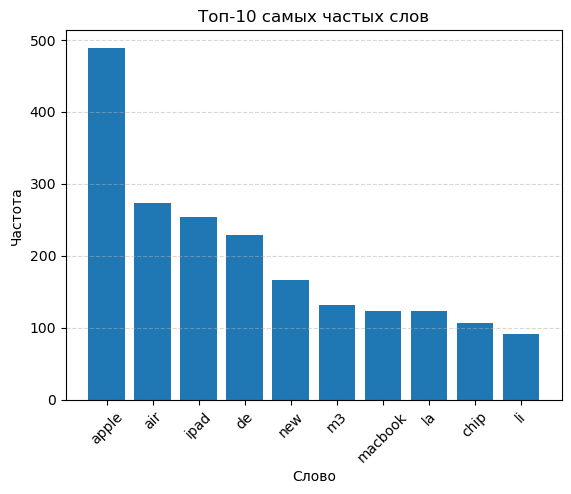

In [21]:
plt.bar(words, count)
plt.title('Топ-10 самых частых слов')
plt.xlabel('Слово')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

### 3.2 Определение тональности текста

In [22]:

nltk.download('vader_lexicon')


def get_text_sentiment(text: str) -> str:
    """Функция определения тональности текста

    Args:
        text (str): исходный текст

    Returns:
        str: тональность (neg, neu, pos, compound)
    """
    sia = SentimentIntensityAnalyzer()
    sentiment_scores = sia.polarity_scores(text)
    return max(sentiment_scores, key=sentiment_scores.get)

data["sentiment"] = data["description"].apply(get_text_sentiment)
data.head(3)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nikol\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,author,title,description,url,publishedAt,content,date,time,sentiment
0,Emma Roth,apple reportedly challenge uk secretive encryp...,apple pushing back uk secret order give govern...,https://www.theverge.com/news/623977/apple-uk-...,2025-03-04 18:29:39+00:00,apple appealing uk backdoor order according fi...,2025-03-04,18:29:39,neu
1,Brenda Stolyar,apple 11 inch 13 inch ipad air price spec avai...,11 inch 13 inch tablet look minor boost perfor...,https://www.wired.com/story/apple-new-ipad-air...,2025-03-04 15:46:35+00:00,less year upgrading ipad air m2 chip apple alr...,2025-03-04,15:46:35,neu
2,Brittany Vincent,apple airtag 4 pack drop 70 amazon 18,buy one apple airtag 4 pack way better deal,https://gizmodo.com/apple-airtag-4-pack-drops-...,2025-03-05 13:10:16+00:00,looking stop losing stuff apple airtags become...,2025-03-05,13:10:16,neu


Ниже решил вспомнить различные варианты визуализации данных

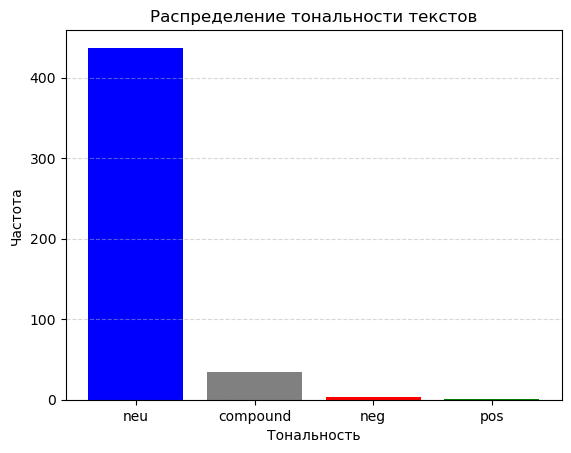

In [23]:
sentiment_counts = data["sentiment"].value_counts()

plt.bar(sentiment_counts.index, sentiment_counts.values, color=["blue", "gray", "red", "green"])
plt.title('Распределение тональности текстов')
plt.xlabel('Тональность')
plt.ylabel('Частота')
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


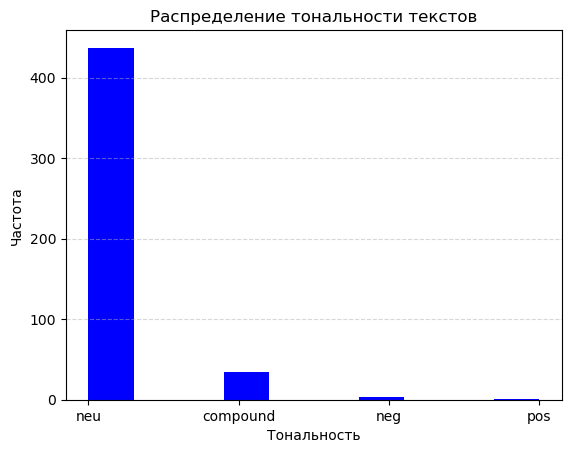

In [24]:
plt.hist(data["sentiment"], color="blue")
plt.title('Распределение тональности текстов')
plt.xlabel('Тональность')
plt.ylabel('Частота')
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

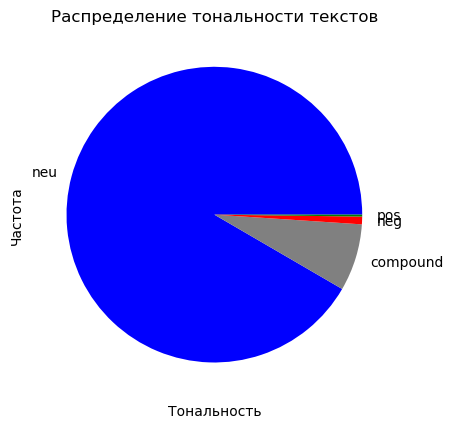

In [25]:
plt.pie(sentiment_counts, labels=sentiment_counts.index, colors=["blue", "gray", "red", "green"])
plt.title('Распределение тональности текстов')
plt.xlabel('Тональность')
plt.ylabel('Частота')
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

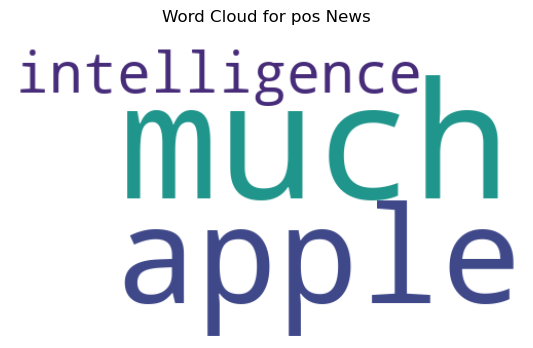

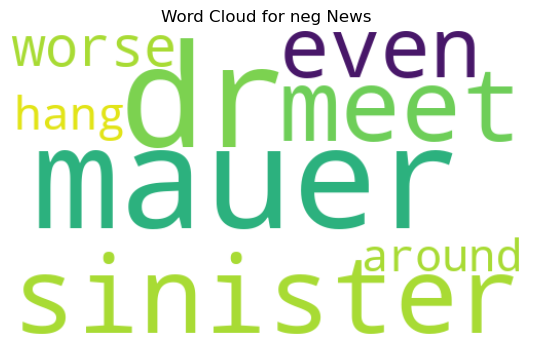

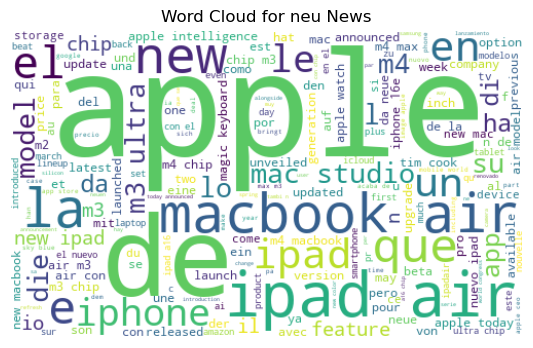

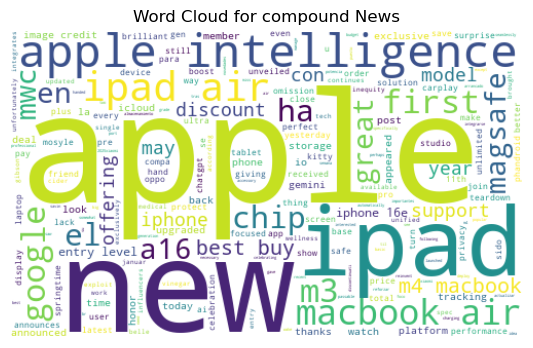

In [27]:
from wordcloud import WordCloud

def plot_wordcloud(sentiment_label):
    text = " ".join(data[data["sentiment"] == sentiment_label]["description"])
    wordcloud = WordCloud(width=500, height=300, background_color="white").generate(text)

    plt.figure(figsize=(7, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment_label} News")
    plt.show()

plot_wordcloud("pos")
plot_wordcloud("neg")
plot_wordcloud("neu")
plot_wordcloud("compound")


### 3.3 Определение главных тем

In [28]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=50)  # Ограничиваем топ-50 ключевых слов
tfidf_matrix = vectorizer.fit_transform(data["description"])

feature_names = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)


In [29]:
tfidf_df

,11,13,18,2025,a16,air,announced,app,apple,chip,...,pro,que,se,studio,su,today,ultra,una,updated,week
0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.354442,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
1,0.627484,0.663617,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
2,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
3,0.000000,0.261927,0.000000,0.00000,0.0,0.271246,0.245561,0.0,0.088108,0.000000,...,0.0,0.0,0.0,0.225972,0.0,0.000000,0.0,0.0,0.0,0.000000
4,0.000000,0.000000,0.000000,0.00000,0.0,0.299795,0.000000,0.0,0.194764,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,0.538484,0.000000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.383138,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
473,0.000000,0.000000,0.000000,0.00000,0.0,0.232101,0.000000,0.0,0.301572,0.297985,...,0.0,0.0,0.0,0.000000,0.0,0.400747,0.0,0.0,0.0,0.000000
474,0.000000,0.000000,0.431577,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000
475,0.000000,0.000000,0.000000,0.63175,0.0,0.000000,0.000000,0.0,0.237704,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.737827


In [30]:
top_n = 5
data["top_keywords"] = tfidf_df.apply(lambda row: row.nlargest(top_n).index.tolist(), axis=1)
data

,author,title,description,url,publishedAt,content,date,time,sentiment,top_keywords
0,Emma Roth,apple reportedly challenge uk secretive encryp...,apple pushing back uk secret order give govern...,https://www.theverge.com/news/623977/apple-uk-...,2025-03-04 18:29:39+00:00,apple appealing uk backdoor order according fi...,2025-03-04,18:29:39,neu,"[intelligence, apple, 11, 13, 18]"
1,Brenda Stolyar,apple 11 inch 13 inch ipad air price spec avai...,11 inch 13 inch tablet look minor boost perfor...,https://www.wired.com/story/apple-new-ipad-air...,2025-03-04 15:46:35+00:00,less year upgrading ipad air m2 chip apple alr...,2025-03-04,15:46:35,neu,"[13, 11, new, 18, 2025]"
2,Brittany Vincent,apple airtag 4 pack drop 70 amazon 18,buy one apple airtag 4 pack way better deal,https://gizmodo.com/apple-airtag-4-pack-drops-...,2025-03-05 13:10:16+00:00,looking stop losing stuff apple airtags become...,2025-03-05,13:10:16,neu,"[apple, 11, 13, 18, 2025]"
3,Sheena Vasani,preorder apple new macbook air mac studio,shortly introducing new ipad ipad air apple an...,https://www.theverge.com/good-deals/624782/app...,2025-03-05 20:27:12+00:00,already preorder new macbook air mac studio mu...,2025-03-05,20:27:12,neu,"[new, mac, m4, ipad, air]"
4,Kyle Barr,apple macbook air m4 finally support 3 screen,m4 macbook air sport similar look last year mo...,https://gizmodo.com/apples-macbook-air-m4-is-h...,2025-03-05 14:34:40+00:00,ultra thin macbook back another 12 round ring ...,2025-03-05,14:34:40,neu,"[feature, model, m4, macbook, air]"
...,...,...,...,...,...,...,...,...,...,...
489,Ed Hardy,ipad 11 chip upgrade bring apple intelligence,ipad 11 get faster processor storage low cost ...,https://www.cultofmac.com/news/ipad-11-release...,2025-03-04 14:50:39+00:00,budget ipad one apple popular new available fa...,2025-03-04,14:50:39,neu,NaN
490,D. Griffin Jones,macbook air get m4 treatment lower price stunn...,today apple revised macbook air m4 chip come b...,https://www.cultofmac.com/news/m4-macbook-air,2025-03-05 14:21:02+00:00,today apple revised macbook air m4 chip come b...,2025-03-05,14:21:02,neu,NaN
491,Aymeric Geoffre-Rouland,actualit io 18 4 active enfin le rcs pour le a...,la deuxi b ta publique io 18 4 apporte avec el...,https://www.lesnumeriques.com/telephone-portab...,2025-03-04 09:51:00+00:00,un moment attendu par beaucoup de propri taire...,2025-03-04,09:51:00,neu,NaN
492,"Maury Brown, Senior Contributor, \n Maury Brow...",friday night mlb doubleheader return apple tv ...,friday night mlb doubleheader return apple tv ...,https://www.forbes.com/sites/maurybrown/2025/0...,2025-03-04 03:18:53+00:00,friday night mlb doubleheader return apple tv ...,2025-03-04,03:18:53,neu,NaN
